In [1]:
import pertpy as pt
import scanpy as sc
import pymde
import numpy as np
import pandas as pd
import seaborn as sns
import anndata as ad
import random
import jax.numpy as jnp 
import itertools
# import spatialscvi as chvae
from openTSNE import TSNE
import chvae 
import scvi
import matplotlib.pyplot as plt
import pandas as pd
# import pertpy
import matplotlib

scvi.settings.dl_num_workers = 0
scvi.settings.seed = 0
from scib_metrics.benchmark import Benchmarker

import jax
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

Seed set to 0
2024-06-17 20:20:06.385117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
adata = pt.dt.norman_2019()

In [3]:
G1_CYCLE = [
    "CDKN1A",
    {"CDKN1B", "CDKN1A"},
    "CDKN1B",
    {"CDKN1C", "CDKN1A"},
    {"CDKN1C", "CDKN1B"},
    "CDKN1C",
]

ERYTHROID = [
    {"CBL", "CNN1"},
    {"CBL", "PTPN12"},
    {"CBL", "PTPN9"},
    {"CBL", "UBASH3B"},
    {"SAMD1", "PTPN12"},
    {"SAMD1", "UBASH3B"},
    {"UBASH3B", "CNN1"},
    {"UBASH3B", "PTPN12"},
    {"UBASH3B", "PTPN9"},
    {"UBASH3B", "UBASH3A"},
    {"UBASH3B", "ZBTB25"},
    {"BPGM", "SAMD1"},
    "PTPN1",
    {"PTPN12", "PTPN9"},
    {"PTPN12", "UBASH3A"},
    {"PTPN12", "ZBTB25"},
    {"UBASH3A", "CNN1"},
]

PIONEER_FACTORS = [
    {"FOXA1", "FOXF1"},
    {"FOXA1", "FOXL2"},
    {"FOXA1", "HOXB9"},
    {"FOXA3", "FOXA1"},
    {"FOXA3", "FOXF1"},
    {"FOXA3", "FOXL2"},
    {"FOXA3", "HOXB9"},
    "FOXA3",
    {"FOXF1", "FOXL2"},
    {"FOXF1", "HOXB9"},
    {"FOXL2", "MEIS1"},
    "HOXA13",
    "HOXC13",
    {"POU3F2", "FOXL2"},
    "TP73",
    "MIDN",
    {"LYL1", "IER5L"},
    "HOXC13",
    {"DUSP9", "SNAI1"},
    {"ZBTB10", "SNAI1"},
]

GRANULOCYTE_APOPTOSIS = [
    "SPI1",
    "CEBPA",
    {"CEBPB", "CEBPA"},
    "CEBPB",
    {"CEBPE", "CEBPA"},
    {"CEBPE", "CEBPB"},
    {"CEBPE", "RUNX1T1"},
    {"CEBPE", "SPI1"},
    "CEBPE",
    {"ETS2", "CEBPE"},
    {"KLF1", "CEBPA"},
    {"FOSB", "CEBPB"},
    {"FOSB", "CEBPE"},
    {"ZC3HAV1", "CEBPA"},
    {"JUN", "CEBPA"},
]

PRO_GROWTH = [
    {"CEBPE", "KLF1"},
    "KLF1",
    {"KLF1", "BAK1"},
    {"KLF1", "MAP2K6"},
    {"KLF1", "TGFBR2"},
    "ELMSAN1",
    {"MAP2K3", "SLC38A2"},
    {"MAP2K3", "ELMSAN1"},
    "MAP2K3",
    {"MAP2K3", "MAP2K6"},
    {"MAP2K6", "ELMSAN1"},
    "MAP2K6",
    {"MAP2K6", "KLF1"},
]

MEGAKARYOCYTE = [
    {"MAPK1", "TGFBR2"},
    "MAPK1",
    {"ETS2", "MAPK1"},
    "ETS2",
    {"CEBPB", "MAPK1"},
]

programmes = {
    "G1 cell cycle": G1_CYCLE,
    "Erythroid": ERYTHROID,
    "Pioneer factors": PIONEER_FACTORS,
    "Granulocyte apoptosis": GRANULOCYTE_APOPTOSIS,
    "Pro-growth": PRO_GROWTH,
    "Megakaryocyte": MEGAKARYOCYTE,
}

In [4]:
gene_programme = []

for target_pert in adata.obs["perturbation_name"]:
    if target_pert == "control":
        gene_programme.append("Control")
        continue

    found_programme = False
    for programme, pert_list in programmes.items():
        for pert in pert_list:
            if (isinstance(pert, set) and pert == set(target_pert.split("+"))) or (target_pert == pert):
                gene_programme.append(programme)
                found_programme = True
                break

    if not found_programme:
        gene_programme.append("Unknown")

adata.obs["gene_programme"] = gene_programme

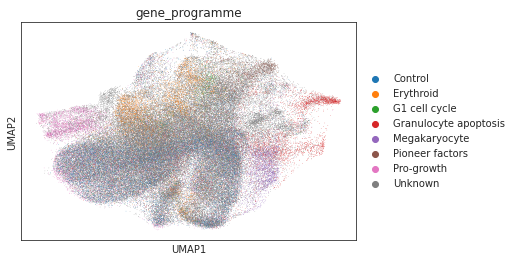

In [5]:
sc.pl.umap(adata, color ='gene_programme')

In [6]:
adata = adata[adata.obs["gene_programme"] != "Unknown"]
adata = adata[adata.obs.number_of_cells == 1]

In [7]:
guide = adata.obs.columns[adata.obs.columns.str.startswith('guide')]
guide = guide.drop(["guide_identity", "guide_ids"])

In [8]:
adata = adata.copy()

In [9]:
adata.obs = adata.obs.astype({col: 'int32' for col in adata.obs.select_dtypes('int64').columns})

In [34]:
adata.obsm["X_scvi"]

KeyError: 'X_scvi'

In [10]:
layers = [1, 3, 5]
for layer in layers:
    chvae.model.JaxSCVI.setup_anndata(adata, design=guide.tolist(), layer="counts")
    model = chvae.model.JaxSCVI(adata, gene_likelihood="nb", n_layer = layer)
    model.train(accelerator='gpu')
    adata.obsm[f"X_hvi_bg{layer}"] = model.get_latent_representation(layer = -2
    )
    adata.obsm[f"X_hvi_salient{layer}"] = model.get_latent_representation(
    )

/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:165: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  getattr(adata, self.attr_name)[self.attr_key] = np.zeros(length, dtype=np.int64)
2024-06-17 20:21:18.275507: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 1/240:   0%|                                                                                                                              | 0/240 [00:00<?, ?it/s]

/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:385: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Epoch 240/240: 100%|█████████████████████████████████████████████████████████| 240/240 [15:14<00:00,  5.43s/it, v_num=1, train_loss_step=8e+3, train_loss_epoch=8.07e+3]

`Trainer.fit` stopped: `max_epochs=240` reached.


Epoch 240/240: 100%|█████████████████████████████████████████████████████████| 240/240 [15:14<00:00,  3.81s/it, v_num=1, train_loss_step=8e+3, train_loss_epoch=8.07e+3]
INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 240/240: 100%|██████████████████████████████████████████████████████| 240/240 [19:08<00:00,  4.61s/it, v_num=1, train_loss_step=8.23e+3, train_loss_epoch=8.07e+3]

`Trainer.fit` stopped: `max_epochs=240` reached.


Epoch 240/240: 100%|██████████████████████████████████████████████████████| 240/240 [19:08<00:00,  4.79s/it, v_num=1, train_loss_step=8.23e+3, train_loss_epoch=8.07e+3]
INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 240/240: 100%|██████████████████████████████████████████████████████| 240/240 [19:53<00:00,  4.92s/it, v_num=1, train_loss_step=8.02e+3, train_loss_epoch=8.07e+3]

`Trainer.fit` stopped: `max_epochs=240` reached.


Epoch 240/240: 100%|██████████████████████████████████████████████████████| 240/240 [19:53<00:00,  4.97s/it, v_num=1, train_loss_step=8.02e+3, train_loss_epoch=8.07e+3]


In [42]:
chvae.model.JaxSCVI.setup_anndata(adata, design=guide.tolist(), layer="counts")
model = chvae.model.JaxSCVI(adata, gene_likelihood="nb", n_layer = layer)
model.train(accelerator='gpu', max_epochs = 400)
adata.obsm[f"X_hvi_bg{layer}"] = model.get_latent_representation(layer = -2
)
adata.obsm[f"X_hvi_salient{layer}"] = model.get_latent_representation(
)

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|███████████████████████████████████████████████████████| 400/400 [31:31<00:00,  4.70s/it, v_num=1, train_loss_step=8.3e+3, train_loss_epoch=8.07e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████████████| 400/400 [31:31<00:00,  4.73s/it, v_num=1, train_loss_step=8.3e+3, train_loss_epoch=8.07e+3]


In [11]:
scvi.external.ContrastiveVI.setup_anndata(adata, layer="counts")
contrastive_vi_model = scvi.external.ContrastiveVI(
    adata,
)
background_indices = np.where(adata.obs["perturbation_name"] == 'control')[0]
target_indices = np.where(adata.obs["perturbation_name"] != 'control')[0]
contrastive_vi_model.train(
    background_indices=background_indices,
    target_indices=target_indices,
    max_epochs = 400
    # early_stopping=True,
    # max_epochs=500,
)
adata.obsm["X_cvi_salient"] = contrastive_vi_model.get_latent_representation(
    adata, representation_kind = "salient"
)
adata.obsm["X_cvi_bg"] = contrastive_vi_model.get_latent_representation(
    adata, representation_kind = "background"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 240/240: 100%|██████████████████████████████████████████████████████| 240/240 [23:03<00:00,  5.70s/it, v_num=1, train_loss_step=1.63e+4, train_loss_epoch=1.64e+4]

`Trainer.fit` stopped: `max_epochs=240` reached.


Epoch 240/240: 100%|██████████████████████████████████████████████████████| 240/240 [23:03<00:00,  5.77s/it, v_num=1, train_loss_step=1.63e+4, train_loss_epoch=1.64e+4]


In [12]:
def cal_umap(adata, use_rep):
    sc.pp.neighbors(adata, use_rep = use_rep)
    sc.tl.umap(adata)
    adata.obsm[use_rep + "_umap"] = adata.obsm["X_umap"]
    del adata.obsm["X_umap"]

In [43]:
adata_reps = ["X_hvi_bg1", "X_hvi_bg3", "X_hvi_bg5", "X_cvi_bg"]
for adata_rep in adata_reps:
    cal_umap(adata, adata_rep)

target_adata = adata[adata.obs.perturbation_name != 'control']
bg_adata = adata[adata.obs.perturbation_name == 'control']

target_adata_reps = ["X_hvi_salient1", "X_hvi_salient3", "X_hvi_salient5", "X_cvi_salient"]
for target_adata_rep in target_adata_reps:
    cal_umap(target_adata, target_adata_rep)

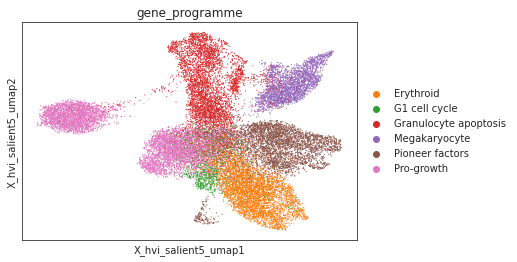

In [47]:
sc.pl.embedding(target_adata, basis = "X_hvi_salient5_umap",  color = "gene_programme")

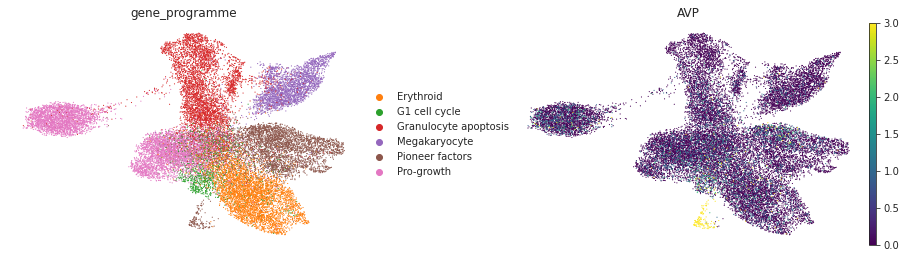

In [64]:
fig = sc.pl.embedding(target_adata, basis = "X_hvi_salient5_umap", color = ['gene_programme', 'AVP'], vmax = 'p99', layer = "counts", cmap = 'viridis', frameon = False, wspace =0.3, show = False)
fig[0].figure.savefig("figures/norman.pdf", bbox_inches = 'tight')

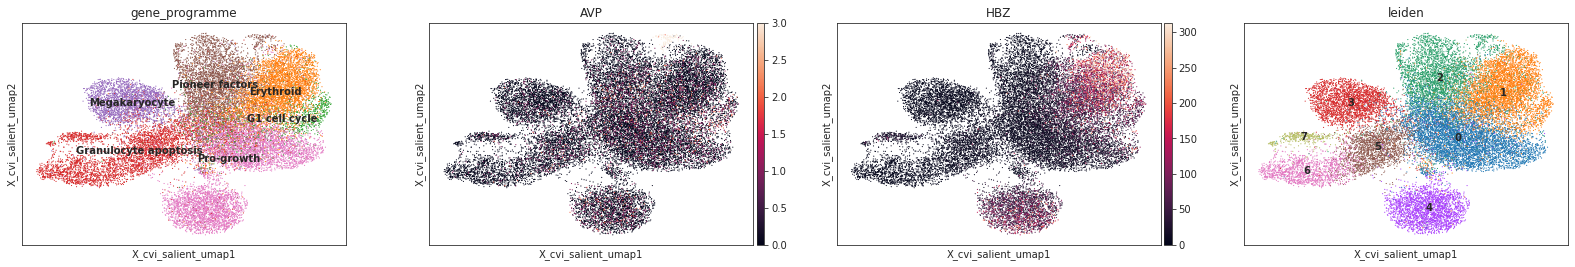

In [31]:
sc.pl.embedding(target_adata, basis = "X_cvi_salient_umap", color = ['gene_programme', 'AVP', "HBZ", 'leiden'], vmax = 'p99', legend_loc = 'on data', layer = "counts")

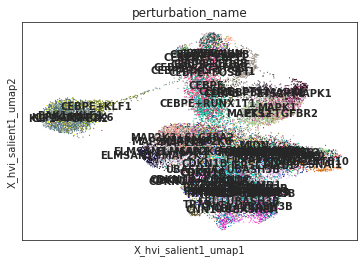

In [16]:
sc.pl.embedding(target_adata, basis = "X_hvi_salient1_umap", color = 'perturbation_name', legend_loc = 'on data')

In [17]:
sc.pp.neighbors(target_adata, use_rep = "X_hvi_salient1")
sc.tl.leiden(target_adata, resolution = 0.4)
sc.tl.rank_genes_groups(target_adata, groupby = "leiden", groups = ['10'], reference = '4')
sc.pl.rank_genes_groups(target_adata)

/tmp/ipykernel_3513828/393366849.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(target_adata, resolution = 0.4)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [48]:
from adjustText import adjust_text
import matplotlib.patheffects as pe

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None, color_by_group=False
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    # Fill the text colors dictionary
    text_colors = {group: None for group in adata.obs[groupby].cat.categories}

    if color_by_group and groupby + "_colors" in adata.uns:
        for i, group in enumerate(adata.obs[groupby].cat.categories):
            if group in exclude:
                continue
            text_colors[group] = adata.uns[groupby + "_colors"][i]

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, color=text_colors[k], **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, color=text_colors[k], **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, only_move = '-x-y', **adjust_kwargs)

In [ ]:
sc.pl.embedding(bg_adata, basis = "X_hvi_bg1_umap", color = 'AVP')

In [53]:
target_adata.obsm['X_umap'] = target_adata.obsm["X_cvi_salient_umap"]

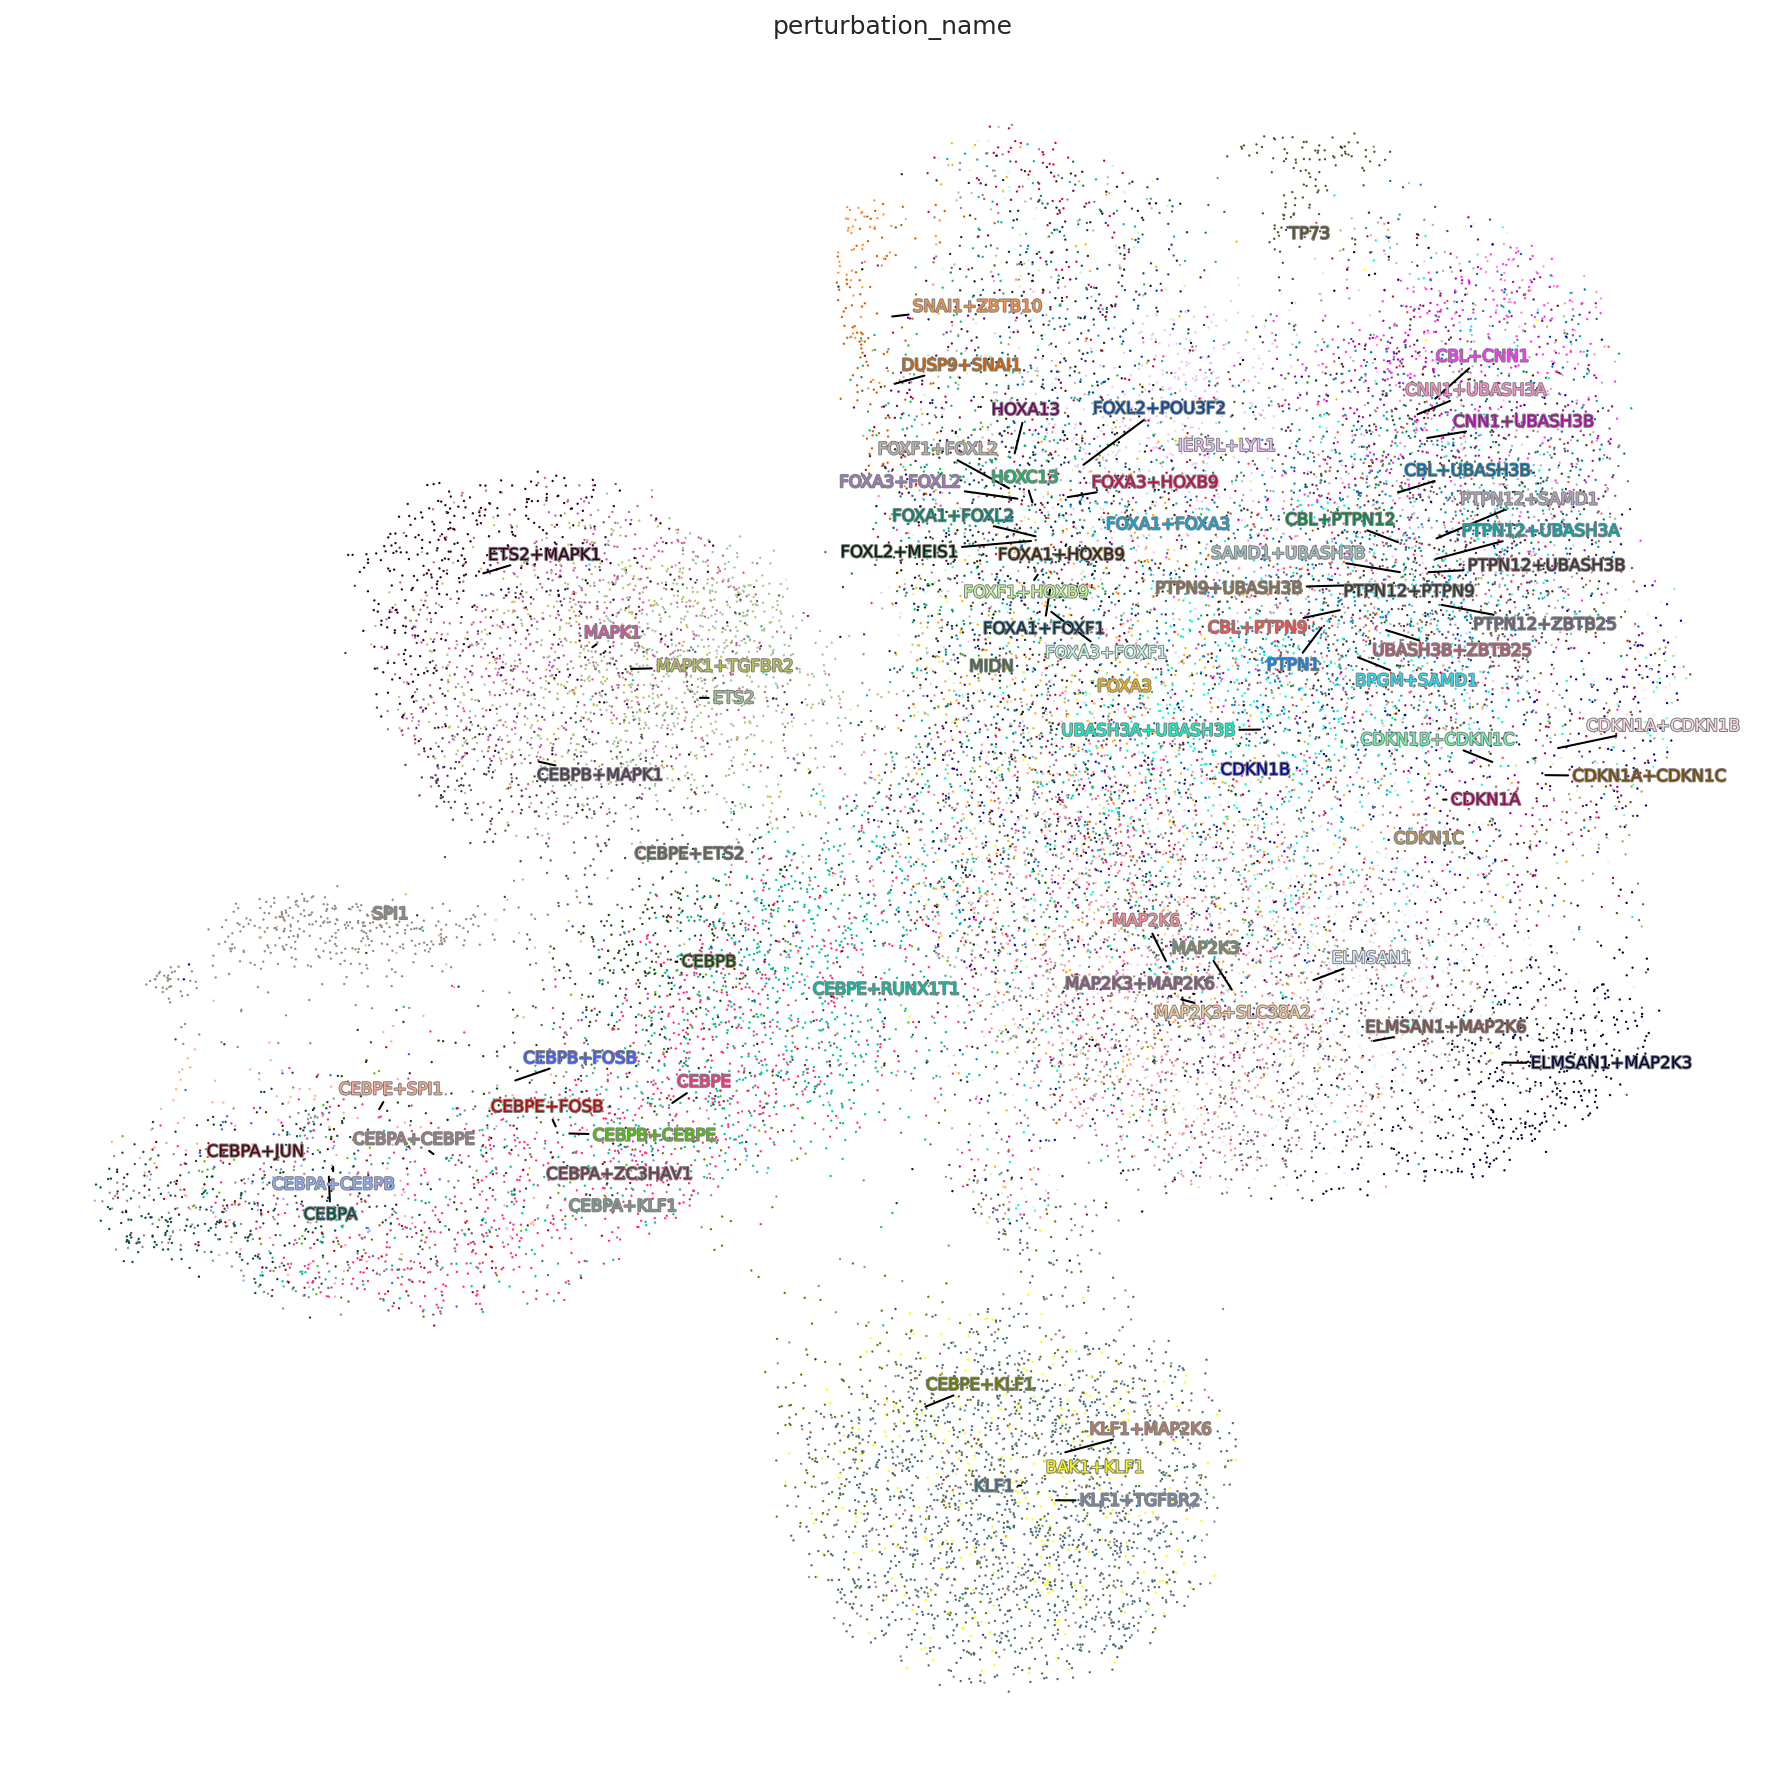

In [54]:
cell_type_key  = 'perturbation_name'
with plt.rc_context({"figure.figsize": (12, 12), "figure.dpi": 150, "figure.frameon": False}):
    ax = sc.pl.umap(target_adata, color=cell_type_key, show=False, legend_loc=None, frameon=False)
    gen_mpl_labels(
        target_adata,
        cell_type_key,
        exclude=("None",),  # This was before we had the `nan` behaviour
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black',)),
        text_kwargs=dict(fontsize=8, path_effects=[pe.withStroke(linewidth=1, foreground="gray")], ),
        color_by_group=True
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.show()

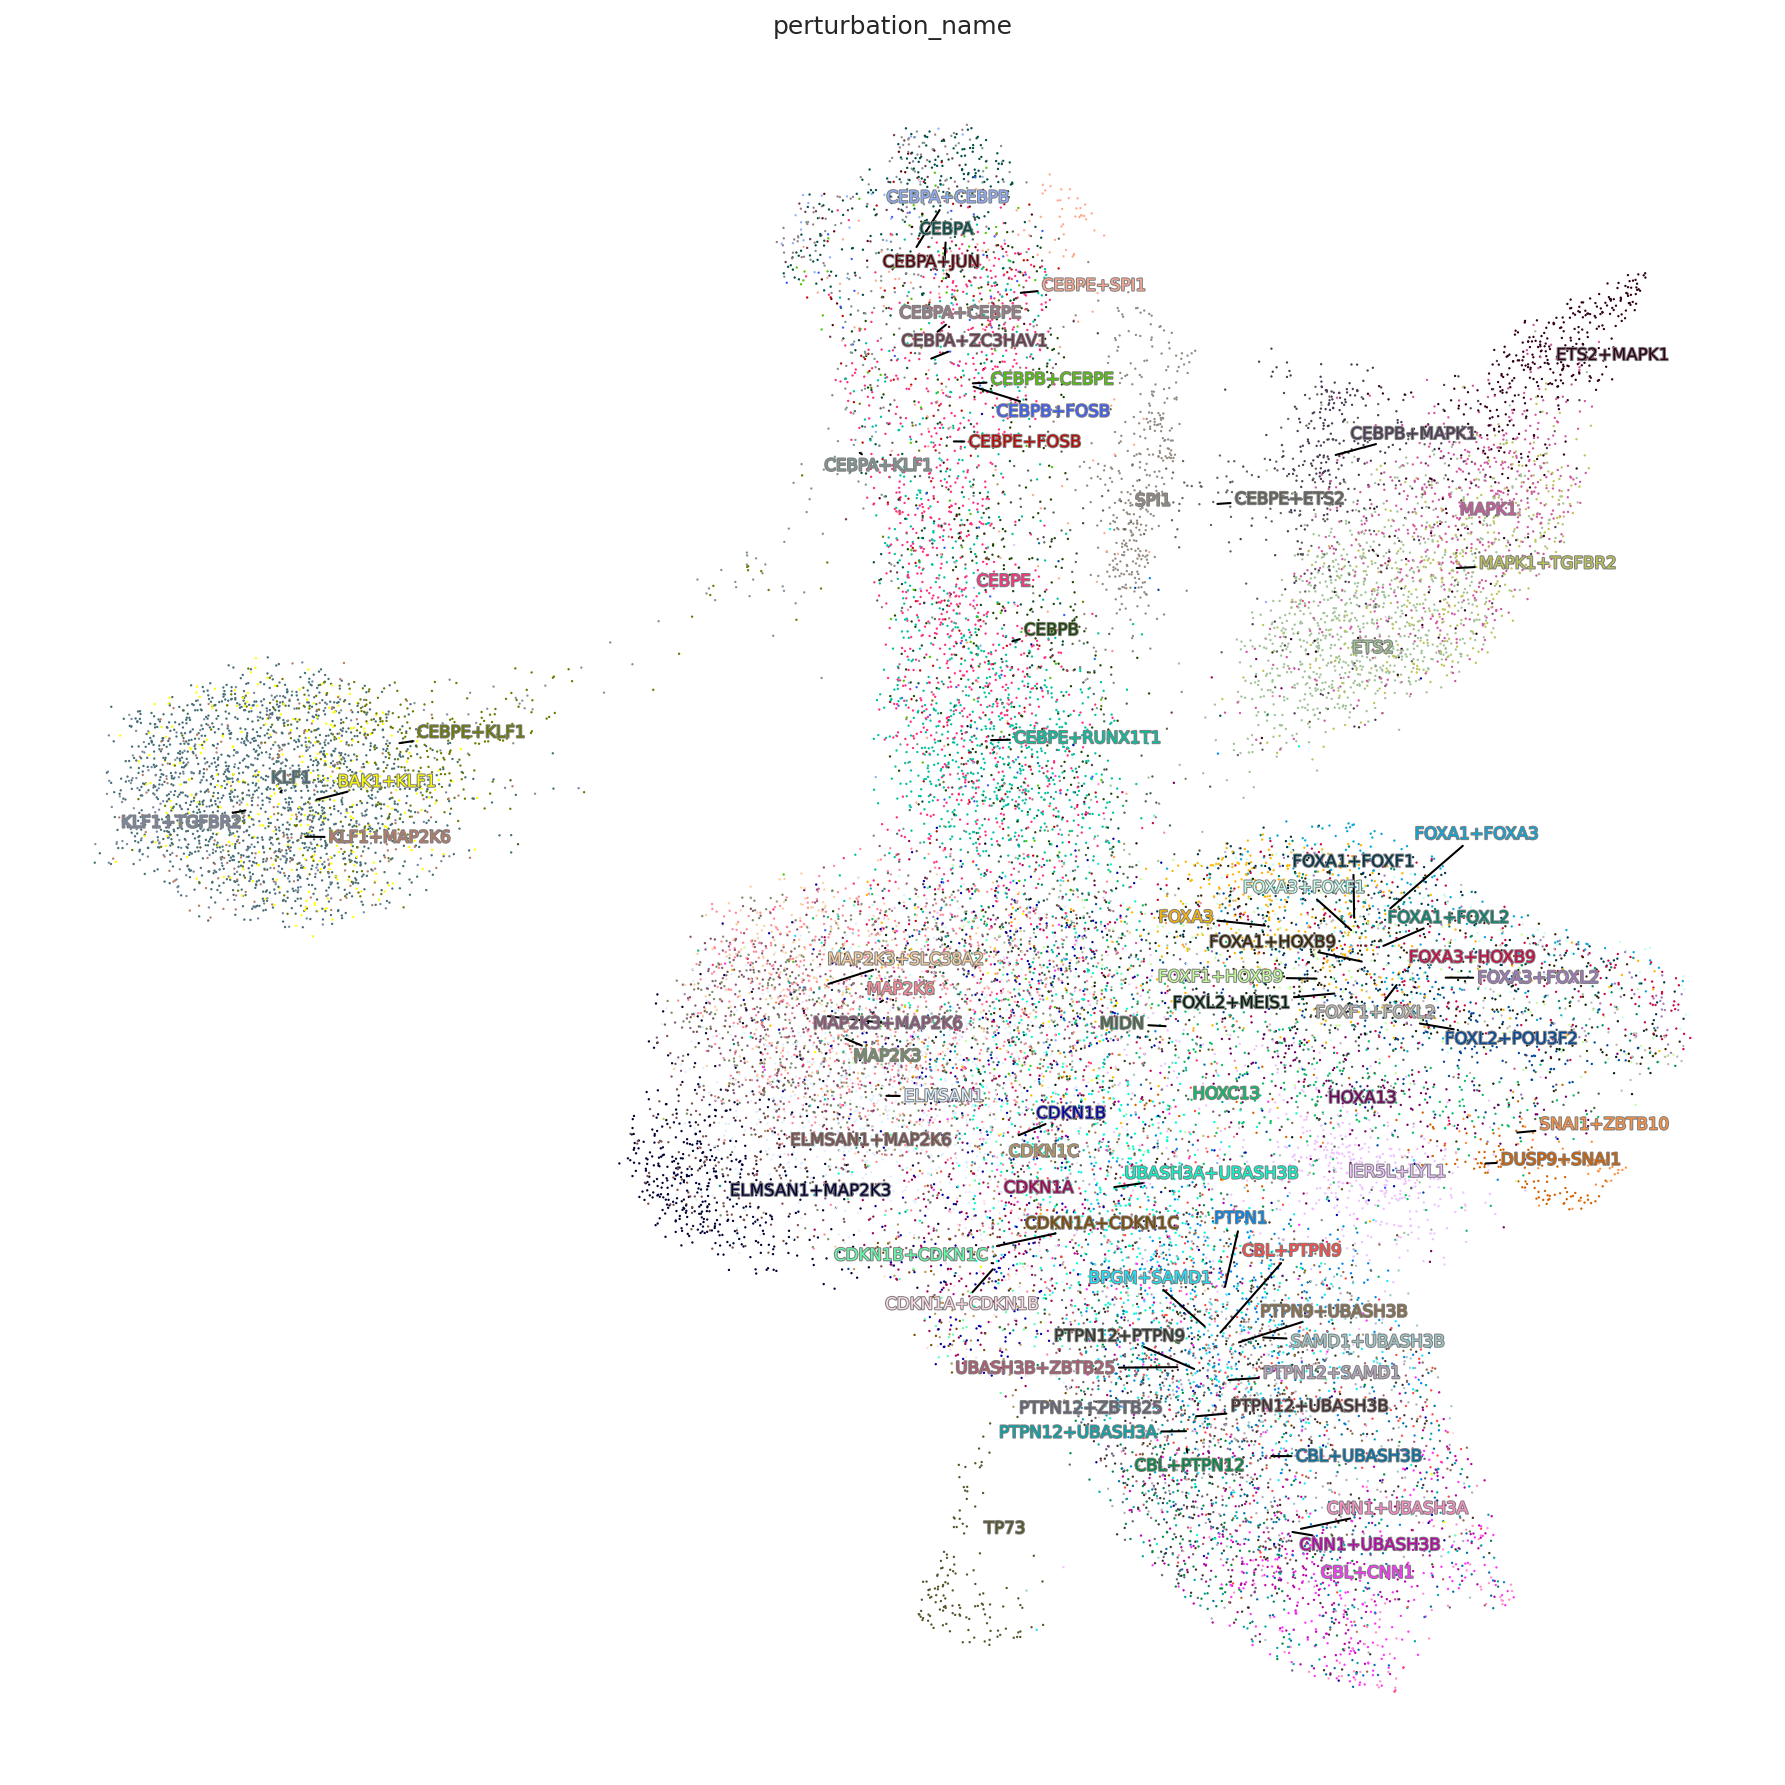

In [52]:
cell_type_key  = 'perturbation_name'
with plt.rc_context({"figure.figsize": (12, 12), "figure.dpi": 150, "figure.frameon": False}):
    ax = sc.pl.umap(target_adata, color=cell_type_key, show=False, legend_loc=None, frameon=False)
    gen_mpl_labels(
        target_adata,
        cell_type_key,
        exclude=("None",),  # This was before we had the `nan` behaviour
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black',)),
        text_kwargs=dict(fontsize=8, path_effects=[pe.withStroke(linewidth=1, foreground="gray")], ),
        color_by_group=True
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.show()

In [ ]:
for i, value in target_adata.obsm.items():
    tmp =  np.float32(target_adata.obsm[i])
    target_adata.obsm[i] = tmp

In [ ]:
bm1 = Benchmarker(
    target_adata,
    batch_key="leiden",
    label_key="gene_programme",
    embedding_obsm_keys=target_adata_reps,
    n_jobs=-1,
)
bm1.benchmark()

In [65]:
bm1.get_results(min_max_scale=False)

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                              
X_hvi_salient1          0.577029          0.487799          0.326956   
X_hvi_salient3          0.555604          0.505517          0.324385   
X_hvi_salient5          0.574478          0.501641          0.331857   
X_cvi_salient           0.554722           0.42219          0.274808   
Metric Type     Bio conservation  Bio conservation  Bio conservation   

                Silhouette label             cLISI  Silhouette batch  \
Embedding                                                              
X_hvi_salient1          0.556074          0.990355          0.798549   
X_hvi_salient3          0.552712          0.988223          0.807223   
X_hvi_salient5          0.546717          0.992169          0.795988   
X_cvi_salient           0.536423           0.97254          0.834324   
Metric Type     Bio conservation  Bio conservation  Batch correction   

                           iLISI              KBET Graph connectivity  \
Embedding                                                               
X_hvi_salient1               0.0          0.176871           0.864151   
X_hvi_salient3          0.001909          0.212398           0.854487   
X_hvi_salient5          0.001743          0.221329           0.859513   
X_cvi_salient           0.011639          0.241315           0.869969   
Metric Type     Batch correction  Batch correction   Batch correction   

                  PCR comparison Batch correction Bio conservation  \
Embedding                                                            
X_hvi_salient1                 0         0.367914         0.587643   
X_hvi_salient3                 0         0.375203         0.585288   
X_hvi_salient5                 0         0.375715         0.589372   
X_cvi_salient                  0         0.391449         0.552137   
Metric Type     Batch correction  Aggregate score  Aggregate score   

                          Total  
Embedding                        
X_hvi_salient1         0.499751  
X_hvi_salient3         0.501254  
X_hvi_salient5         0.503909  
X_cvi_salient          0.487862  
Metric Type     Aggregate score

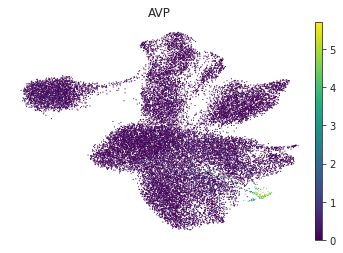

In [40]:
sc.pl.embedding(target_adata, basis = "X_hvi_salient3_umap", frameon= False, color = "AVP", cmap = "viridis")

In [ ]:
sc.pl.embedding(target_adata[target_adata.obs.gene_programme == "Pioneer factors"] , basis = "X_hvi_salient3_umap", frameon= False, color = "perturbation_name", cmap = "viridis")